# Setup

In [149]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

## Load data

In [150]:
# Load dataframe
bd = pd.read_pickle("./data/batting_data_ch7.pkl")

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0_mle, beta0_mle = np.load(f)

## 8.2 Right- and left- handed batters
First we need to add the batter handedness to the dataframe. 

In [151]:
from pybaseball.lahman import people

people_data = people()

def get_batter_handedness(row,people_data):
    row["bats"] = people_data.loc[people_data.playerID.isin([row.playerID]),"bats"].item()
    return row

bd = bd.apply(lambda row: get_batter_handedness(row,people_data),axis=1)

Drop players w/o batting data and one-hot encode our batting column.

In [152]:
bd = bd.dropna(subset=["bats"])
bd = pd.get_dummies(bd, columns=['bats'])
# DO I NEED TO DROP A COLUMN HERE? YES IF STANDARD OLS, NO IF REGUlARIZATION ... need to test this

In [153]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    # Get H/AB 
    k, n, r, l, b = args # H, AB, R-handed, L-handed, Both-handed

    # The initial model assumed a fixed (alpha, beta):
    #        a, b = params[0], params[1]

    # Here, we take in the initial values of (mu_0, mu_ab, and sigma_0) to compute (alpha, beta):
    mu_0, mu_AB, sigma_0, r0, l0, b0 = params
    # Add batting term
    batting_term = r0*r + l0*l + b0*b
    mu_i = mu_0 + mu_AB*np.log(n) + batting_term
    # (alpha,beta) as before
    a = mu_i / sigma_0
    b = (1-mu_i)/sigma_0
    
    # Log pdf
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #


min_atbat = 0

# I am going to cheat here and use the values from the book as initial parameters since MLE is probably not the best choice here.
init_params = [ 0.14348183, 0.01514047, 0.00175561, 0.01,        0.01,    0.01]
param_bounds = [(0, 0.4), (0.001, 0.5),(.0001,.1),(-0.5,.5),(-0.5,.5),(-0.5,.5)]

# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(bd.loc[:,'H'], bd.loc[:,'AB'],bd.loc[:,'bats_R'],bd.loc[:,'bats_L'],bd.loc[:,'bats_B']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000},bounds=param_bounds)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48202D+04    |proj g|=  5.10000D-01

At iterate    1    f=  3.44094D+04    |proj g|=  5.04529D-01

At iterate    2    f=  3.43069D+04    |proj g|=  5.05363D-01

At iterate    3    f=  3.42405D+04    |proj g|=  5.06350D-01

At iterate    4    f=  3.42353D+04    |proj g|=  5.06438D-01

At iterate    5    f=  3.42154D+04    |proj g|=  5.05360D-01

At iterate    6    f=  3.41669D+04    |proj g|=  5.02538D-01

At iterate    7    f=  3.41377D+04    |proj g|=  5.02310D-01

At iterate    8    f=  3.41365D+04    |proj g|=  5.02258D-01

At iterate    9    f=  3.41361D+04    |proj g|=  5.02002D-01

At iterate   10    f=  3.41354D+04    |proj g|=  5.01591D-01

At iterate   11    f=  3.41336D+04    |proj g|=  5.01637D-01

At iterate   12    f=  3.41310D+04    |proj g|=  5.10029D-01

At iterate   13    f=  3.4

In [154]:
print(result)

      fun: 34122.977296519784
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.20853656, -10.12158464,  -2.66882125,  -0.47075446,
        -0.54133125,  -0.21464075])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 189
      nit: 21
     njev: 27
   status: 0
  success: True
        x: array([ 0.14132231,  0.01500157,  0.0016237 ,  0.00052083,  0.00965981,
       -0.00124124])


In [155]:
def new_eb_estimate(row,params,col_names=["alpha0_bat","beta0_bat","alpha1_bat","beta1_bat","eb_estimate_bat"]):

    # Get H and AB for each row
    H, AB, R, L, B = row.H, row.AB, row.bats_R, row.bats_L, row.bats_B
    
    # Get values from MLE results
    mu, mu_AB, sigma, r_, l_, b_ = params

    # Update alpha0 and beta0
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term) if AB > 0 else mu
    alpha0 = mu_i/sigma
    beta0 = (1-mu_i)/sigma

    # Update alpha1 and beta1
    alpha1 = alpha0 + H
    beta1  = beta0 + (AB - H)

    # New eb estimate
    new_eb_estimate = alpha1 / (alpha1 + beta1)

    # Update data
    row[col_names[0]] = alpha0 
    row[col_names[1]]  = beta0 
    row[col_names[2]] = alpha1
    row[col_names[3]]  = beta1
    row[col_names[4]] = new_eb_estimate

    return row

bd = bd.loc[bd.AB>0,:].apply(lambda row: new_eb_estimate(row,result.x),axis=1)

## Figure 8.1 
The prior distribution according to the hierarchical model for players with particular combinations of AB and handedness.

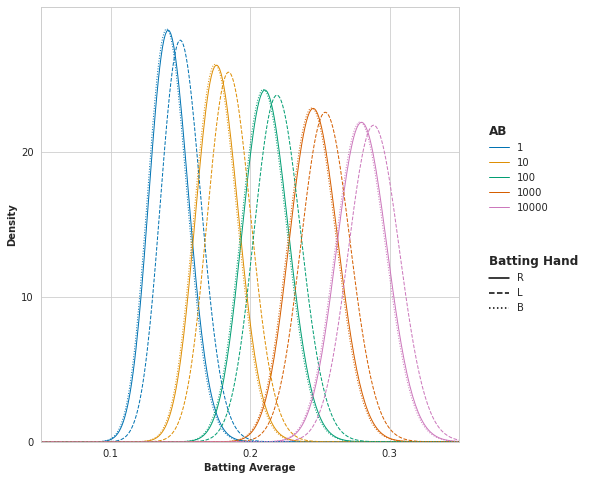

In [156]:
# Which ABs
ABs = [1,10,100,1000,10000]

def get_alpha0_beta0(params,AB=1,bats=[1,0,0]):
    # Convert to list if not lsit
    R,L,B = bats
    # Get params from MLE 
    # mu, mu_AB, sigma = .1426,.0153,np.exp(-6.2935)
    mu, mu_AB, sigma, r_, l_, b_ = params
    # sigma = np.exp(sigma)
    # Initialize and loop through each AB value
    alpha0, beta0 = [],[]
    # Update alpha0 and beta0
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term) if AB > 0 else mu
    a = mu_i / sigma
    b = (1-mu_i)/sigma

    return a, b # returns pair of alpha0,beta0 values

# Make figure - I know there are other ways to add a second legend but I prefer to use gridspec so I have complete control of everything..
with sns.axes_style("whitegrid"):
    
    # Create figure
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(7.5,8)

    # Add gridspecs
    gs0 = fig.add_gridspec(nrows=1, ncols=1)#, left=0.1, right=0.75,bottom=0.9,top=.99)#,width_ratios=[1,1,1])
    ax0 = fig.add_subplot(gs0[0],facecolor="w",)
    gs1 = fig.add_gridspec(nrows=1, ncols=1)
    ax1 = fig.add_subplot(gs1[0],facecolor="None",)
    
    # Define colors
    clrs = sns.color_palette("colorblind",n_colors=len(ABs))

    # Plot data for each AB/handed combo
    bat_vec = [[1,0,0],[0,1,0],[0,0,1]]
    bat_side = ["R","L","B"]
    linestyles = ["-","--",":"]
    x = np.linspace(0,1,1000)
    for (_bats,_batside,_linesty) in zip(bat_vec,bat_side,linestyles):
        for (clr,AB) in zip(clrs,ABs):
            a0,b0 = get_alpha0_beta0(result.x,AB,_bats)
            if _batside == "R": # add label
                ax0.plot(x,stats.beta.pdf(x,a0,b0),color=clr,lw=1,linestyle=_linesty,label="{}".format(AB))
            else: # no label
                ax0.plot(x,stats.beta.pdf(x,a0,b0),color=clr,lw=1,linestyle=_linesty)
    
    # Add invisible plots for batting hand
    for (_linesty,_bats) in zip(linestyles,bat_side):
        ax1.plot([], [], color="k", alpha=1, linestyle=_linesty, label="{}".format(_bats))

    # # Add legend and clean up
    ax0.legend(frameon=False,bbox_to_anchor=(1.05,.75),loc='upper left')   
    ax0.get_legend().set_title("AB",prop = {'size':12,'weight': "bold"})
    ax0.get_legend()._legend_box.align = "left"
    ax0.set_xlabel("Batting Average",fontweight="bold")
    ax0.set_ylabel("Density",fontweight="bold")
    ax0.set_xticks([0.1,0.2,0.3])
    ax0.set_xlim(0.05,.35)
    ax0.set_yticks([0,10,20])
    ax0.set_ylim(0,30)

    # Second legend and axes
    ax1.legend(frameon=False,bbox_to_anchor=(1.05,.45),loc='upper left')   
    ax1.get_legend().set_title("Batting Hand",prop = {'size':12,'weight': "bold"})
    ax1.get_legend()._legend_box.align = "left"
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)

## Figure 8.2
Empirical Bayes estimates and 95% credible intervals for two hypothetical batters with a 30% success rate, one left-handed and one right-handed.

In [157]:
def get_credible_intervals(data,ci=[0.025,0.975]):
        # Get explicit credible intervals
        data["cred_low"], data["cred_high"] = stats.beta.ppf(ci,data["alpha1"],data["beta1"])
        # Get difference between mean and CIs since that is what matplotlib.pyplot.errorbar wants
        data["cred_low_diff"], data["cred_high_diff"] = np.absolute(data["eb_estimate"]-data["cred_low"]), np.absolute(data["eb_estimate"]-data["cred_high"])
        return data

# Define batter dataframes
AB  = [10,100,1000,10000]
H   = [ii*(3/10) for ii in AB]
Avg = [(ii[0]/ii[1]) for ii in zip(H,AB)]
batter = pd.DataFrame({"AB":2*AB, "H": 2*H, "Avg": 2*Avg, "Bats": len(AB)*["R"] + len(AB)*["L"],"bats_R": len(AB)*[1] + len(AB)*[0],"bats_L": len(AB)*[0] + len(AB)*[1],"bats_B": len(AB)*[0] + len(AB)*[0]})

# Get alphas and EB estimate for each combo of (AB, Batting hand) 
batter = batter.apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0","beta0","alpha1","beta1","eb_estimate"]),axis=1)

# Get alphas and EB estimate for each combo of (AB, Batting hand) 
batter= batter.apply(lambda row: get_credible_intervals(row),axis=1)
batter

,AB,H,Avg,Bats,bats_R,bats_L,bats_B,alpha0,beta0,alpha1,beta1,eb_estimate,cred_low,cred_high,cred_low_diff,cred_high_diff
0,10,3.0,0.3,R,1,0,0,108.952873,506.925861,111.952873,513.925861,0.178873,0.149866,0.209824,0.029007,0.030951
1,100,30.0,0.3,R,1,0,0,130.226803,485.651931,160.226803,555.651931,0.223818,0.194054,0.255044,0.029765,0.031226
2,1000,300.0,0.3,R,1,0,0,151.500733,464.378000,451.500733,1164.378000,0.279415,0.257806,0.301541,0.021609,0.022126
3,10000,3000.0,0.3,R,1,0,0,172.774663,443.104070,3172.774663,7443.104070,0.298871,0.290199,0.307614,0.008671,0.008743
4,10,3.0,0.3,L,0,1,0,114.260606,501.618127,117.260606,508.618127,0.187354,0.157776,0.218823,0.029578,0.031470
5,100,30.0,0.3,L,0,1,0,135.534536,480.344197,165.534536,550.344197,0.231233,0.201095,0.262792,0.030137,0.031560
6,1000,300.0,0.3,L,0,1,0,156.808467,459.070267,456.808467,1159.070267,0.282700,0.261009,0.304900,0.021691,0.022200
7,10000,3000.0,0.3,L,0,1,0,178.082397,437.796337,3178.082397,7437.796337,0.299371,0.290695,0.308118,0.008676,0.008747


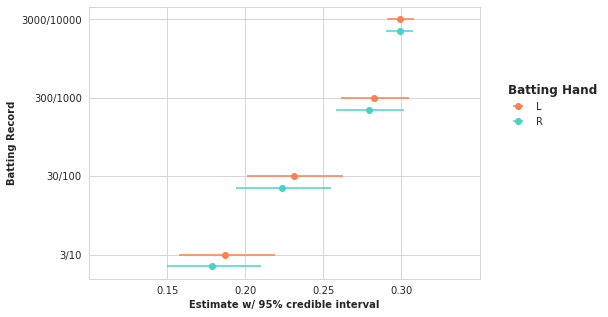

In [158]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Group by batting hand
    grouped = batter.groupby(by="Bats")
    y_jit = [np.arange(len(AB)),np.arange(len(AB))-.15]
    for (G,clr,yy) in zip(grouped,['coral','mediumturquoise'],y_jit):
        # get group
        name, group = G
        group = group.sort_values(by="AB",ascending=True)
        # Get credible intervals as list of tuples
        credible_intervals   = np.abs(group.loc[:,["cred_low_diff","cred_high_diff"]].transpose().to_numpy())
        ax.errorbar(x=group.loc[:,"eb_estimate"],y=yy,xerr=credible_intervals,color=clr,fmt='o',label=name)
            
    # Clean up
    ax.set_xticks([.15, .2,.25,.3],)
    ax.set_xlim(.1,.35)
    ax.legend(frameon=False,bbox_to_anchor=(1.05,.75),loc='upper left')   
    ax.get_legend().set_title("Batting Hand",prop = {'size':12,'weight': "bold"})
    ax.get_legend()._legend_box.align = "left"
    ax.set_yticks(np.arange(len(AB)))   
    yticklabs = [str(int(ii[0])) + "/" + str(int(ii[1])) for ii in zip(H,AB)]
    ax.set_yticklabels(yticklabs)
    ax.set_xlabel("Estimate w/ 95% credible interval",fontweight="bold")
    ax.set_ylabel("Batting Record",fontweight="bold")


## 8.3 Over time

In [159]:
from pybaseball.lahman import batting
batting_data = batting()

def get_year(row,batting_data):
    row["Year"] = batting_data.loc[batting_data.playerID.isin([row.playerID]),"yearID"].item()
    row["Decade"] = (row.Year//10)*10
    return row

# Get players that are needed, group by player, and take mean of their years played
batting_data = batting_data.loc[batting_data.playerID.isin(bd.playerID),["yearID","playerID"]].groupby(by="playerID",as_index=True).mean().astype(int).reset_index()
bd = bd.apply(lambda row: get_year(row,batting_data),axis=1)

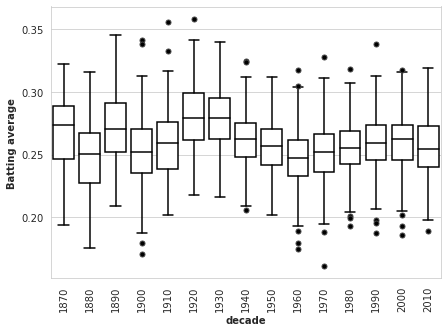

In [160]:

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    props = {'flierprops': {"markerfacecolor": 'k', "markersize": 5,
                "linestyle":'none',"marker": 'o'},
        'boxprops':{'facecolor':'w', 'edgecolor':'k'},
        'medianprops':{'color':'k'},
        'whiskerprops':{'color':'k'},
        'capprops':{'color':'k'}
    }
    sns.boxplot(data=bd.loc[bd.AB > 500,:],x="Decade",y="Avg",**props)
    ax.set_yticks([.2, .25, .3, .35])
    ax.set_xlabel("decade",fontweight="bold")
    ax.set_ylabel("Batting average",fontweight="bold")
    plt.xticks(rotation = 90)


The closest thing to `ns(year, df = 5)` in `R` is natural cubic regression splines using [`patsy`](https://patsy.readthedocs.io/en/latest/spline-regression.html?highlight=cr#natural-and-cyclic-cubic-regression-splines) in `python`.

In [216]:
bd = bd.loc[:,~bd.columns.isin(["year_basis1","year_basis2","year_basis3"])]

In [217]:
from patsy import dmatrix

# First output not dataframe for use on new data
basis= dmatrix("cr(train['Year'],df = 3)", {"train": bd[["Year"]]})

# Get dataframe for our existing data
basis_df = dmatrix("cr(train['Year'],df = 3)", {"train": bd[["Year"]]}, return_type='dataframe').rename(columns={"cr(train['Year'], df=3)[0]": "year_basis1",
                                                                                                              "cr(train['Year'], df=3)[1]": "year_basis2",
                                                                                                              "cr(train['Year'], df=3)[2]": "year_basis3"})
# Add to existing dataframe                                                                                                              
bd = pd.concat([bd,basis_df.loc[:, basis_df.columns != "Intercept"]],axis=1)

In [218]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    # Get H/AB 
    k, n, r, l, b, y1, y2, y3 = args # H, AB, R-handed, L-handed, Both-handed, year 1, year 2, year 3 

    # The initial model assumed a fixed (alpha, beta):
    #        a, b = params[0], params[1]

    # Here, we take in the initial values of (mu_0, mu_ab, and sigma_0) to compute (alpha, beta):
    mu_0, mu_AB, sigma_0, r0, l0, b0, y1_0, y2_0, y3_0 = params
    # Add batting term
    year_term    = y1_0*y1 + y2_0*y2 + y3_0*y3
    batting_term = r0*r + l0*l + b0*b
    mu_i = mu_0 + mu_AB*np.log(n) + batting_term + year_term
    # (alpha,beta) as before
    a = mu_i / sigma_0
    b = (1-mu_i)/sigma_0
    
    # Log pdf
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #


min_atbat = 0

# I am going to cheat here and use the values from the book as initial parameters since MLE is probably not the best choice here.
init_params = [ 0.14348183, 0.01514047, 0.00175561,  0.01,       0.01,     0.01,      0.01,      0.01,      0.01]
param_bounds = [(0, 0.4), (0.001, 0.5),(.0001,.1),(-0.5,.5),  (-0.5,.5), (-0.5,.5), (-0.5,.5), (-0.5,.5), (-0.5,.5)]

# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(bd.loc[:,'H'], bd.loc[:,'AB'],bd.loc[:,'bats_R'],bd.loc[:,'bats_L'],bd.loc[:,'bats_B'], bd.loc[:,'year_basis1'], bd.loc[:,'year_basis2'], bd.loc[:,'year_basis3']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000},bounds=param_bounds)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65496D+04    |proj g|=  5.10000D-01

At iterate    1    f=  3.51260D+04    |proj g|=  5.02239D-01

At iterate    2    f=  3.46570D+04    |proj g|=  5.00589D-01

At iterate    3    f=  3.43866D+04    |proj g|=  5.05145D-01

At iterate    4    f=  3.42715D+04    |proj g|=  5.03866D-01

At iterate    5    f=  3.42488D+04    |proj g|=  5.04026D-01

At iterate    6    f=  3.42354D+04    |proj g|=  5.03854D-01

At iterate    7    f=  3.42323D+04    |proj g|=  5.03844D-01

At iterate    8    f=  3.42206D+04    |proj g|=  5.03557D-01

At iterate    9    f=  3.42045D+04    |proj g|=  5.02940D-01

At iterate   10    f=  3.41596D+04    |proj g|=  5.00642D-01

At iterate   11    f=  3.41264D+04    |proj g|=  5.03668D-01

At iterate   12    f=  3.41155D+04    |proj g|=  5.04350D-01

At iterate   13    f=  3.4

In [219]:
print(result)

      fun: 34086.41880524196
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.67448127, -2.96568032,  6.69169822,  1.78188202, -2.66663847,
        0.2059096 ,  0.52241376, -0.15570549, -1.18816388])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 670
      nit: 60
     njev: 67
   status: 0
  success: True
        x: array([ 0.14089228,  0.01509687,  0.00158511, -0.00083649,  0.00838646,
       -0.00154232,  0.00646548,  0.00217672, -0.00263439])


In [220]:
def new_eb_estimate(row,params,col_names=["alpha0","beta0","alpha1","beta1","eb_estimate"]):

    # Get H,AB, and other params for each row
    H, AB, R, L, B, Y1, Y2, Y3 = row.H, row.AB, row.bats_R, row.bats_L, row.bats_B, row.year_basis1, row.year_basis2, row.year_basis3
    
    # Get values from MLE results
    mu, mu_AB, sigma, r_, l_, b_, y1_, y2_, y3_ = params

    # Update alpha0 and beta0
    year_term    = y1_*Y1 + y2_*Y2 + y3_*Y3
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term + year_term) if AB > 0 else mu
    alpha0 = mu_i/sigma
    beta0 = (1-mu_i)/sigma

    # Update alpha1 and beta1
    alpha1 = alpha0 + H
    beta1  = beta0 + (AB - H)

    # New eb estimate
    new_eb_estimate = alpha1 / (alpha1 + beta1)

    # Update data
    row[col_names[0]] = alpha0 
    row[col_names[1]] = beta0 
    row[col_names[2]] = alpha1
    row[col_names[3]] = beta1
    row[col_names[4]] = new_eb_estimate

    return row

bd = bd.loc[bd.AB>0,:].apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0_year","beta0_year","alpha1_year","beta1_year","eb_estimate_year"]),axis=1)

In [221]:
# Which ABs
ABs = [1,10,100,1000,10000]

def get_alpha0_beta0(params,AB=1,bats=[1,0,0]):
    # Convert to list if not lsit
    R,L,B = bats
    # Get params from MLE 
    # mu, mu_AB, sigma = .1426,.0153,np.exp(-6.2935)
    mu, mu_AB, sigma, r_, l_, b_ = params
    # sigma = np.exp(sigma)
    # Initialize and loop through each AB value
    alpha0, beta0 = [],[]
    # Update alpha0 and beta0
    batting_term = r_*R + l_*L + r_*R
    mu_i = (mu + mu_AB*np.log(AB) + batting_term) if AB > 0 else mu
    a = mu_i / sigma
    b = (1-mu_i)/sigma

    return a, b # returns pair of alpha0,beta0 values

In [222]:
def get_credible_intervals(data,ci=[0.025,0.975]):
        # Get explicit credible intervals
        data["cred_low"], data["cred_high"] = stats.beta.ppf(ci,data["alpha1"],data["beta1"])
        # Get difference between mean and CIs since that is what matplotlib.pyplot.errorbar wants
        data["cred_low_diff"], data["cred_high_diff"] = np.absolute(data["eb_estimate"]-data["cred_low"]), np.absolute(data["eb_estimate"]-data["cred_high"])
        return data

# Define batter dataframes
AB  = [10,100,1000,10000]
H   = [ii*(3/10) for ii in AB]
Year = np.arange(1970,2020)
Avg = [(ii[0]/ii[1]) for ii in zip(H,AB)]
# batter = pd.DataFrame({"AB":2*AB, "H": 2*H, "Avg": 2*Avg, "Bats": len(AB)*["R"] + len(AB)*["L"],"bats_R": len(AB)*[1] + len(AB)*[0],"bats_L": len(AB)*[0] + len(AB)*[1],"bats_B": len(AB)*[0] + len(AB)*[0]})

# Get alphas and EB estimate for each combo of (AB, Batting hand) 
batter = batter.apply(lambda row: new_eb_estimate(row,result.x,col_names=["alpha0","beta0","alpha1","beta1","eb_estimate"]),axis=1)

# Get alphas and EB estimate for each combo of (AB, Batting hand) 
batter= batter.apply(lambda row: get_credible_intervals(row),axis=1)
batter

AttributeError: 'Series' object has no attribute 'year_basis1'

In [125]:
# np.arange(1970,2021)
# Make figure
import itertools

# Define "batters"
AB   = [100,1000,10000]
AVG  = [.2, .25, .3]
YEAR = np.arange(1970,2021)

out = patsy.dmatrix(basis.design_info, {'train': pd.DataFrame({"Year": YEAR})}, return_type='dataframe')

with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(len(AB),len(AVG))
    fig.set_size_inches(10,10)
    # Loop through each axis
    for (thisax,(aa,bb)) in zip(ax,list(itertools.product(*[AVG,AB]))):
        # Set thisax as current axis
        plt.sca(thisax)






SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2215868882.py, line 8)